In [17]:
# Setup
# !pip install git+git://github.com/ntasfi/PyGame-Learning-Environment
# !pip install pygame moviepy

In [26]:
from ple import PLE
from ple.games.flappybird import FlappyBird
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

# %matplotlib inline
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

In [19]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

{'up': 119}
[119, None]


In [20]:
# a dictionary describe state
'''
    player y position.
    players velocity.
    next pipe distance to player
    next pipe top y position
    next pipe bottom y position
    next next pipe distance to player
    next next pipe top y position
    next next pipe bottom y position
'''
game.getGameState()  

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

# SARSA Model

Q(S, A) = Q(S, A) + Leaning Rate * (reward + gamma \* Q(S', A') - Q(S, A))

A' = A

S' = S


In [21]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime, action_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        # best_q = np.max(self.q_table[state_prime_idx])
        best_q = self.q_table[state_prime_idx][action_prime]
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * best_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        ** ((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0


In [22]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)


# Animation Maker

In [23]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

# Training SARSA
Since I use ```runipy``` to excute this notebook, I only print some of result here. The videos of training is on Google Drive.

All videos of training

[Videos](https://drive.google.com/drive/folders/1RYHOu40j5J1R_1kogQqouhwB3v6Ysq5Y?usp=sharing)

The best result

[Best](https://drive.google.com/file/d/1QaVZNC9itTJicpWtpVkO-w3gnjbbSxEX/view?usp=sharing)

In [24]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # cumulate reward for this episode
    cum_reward = 0  
    t = 0

    # select an action
    # Modify
    action = agent.select_action(state)

    while not env.game_over():
        # execute the action and get reward
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])  

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # select the next action
        # Modify
        action_prime = agent.select_action(state_prime)

        # update agent
        agent.update_policy(state, action, reward, state_prime, action_prime)

        # Setting up for the next iteration
        state = state_prime
        # Modify
        action = action_prime


        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode %d finished after %f time steps" % (episode, t))
        print("cumulated reward: %f" % cum_reward)
        print("exploring rate %f" % agent.exploring_rate)
        print("learning rate %f" % agent.learning_rate)
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

t:  29%|██▊       | 18/63 [00:00<00:00, 177.25it/s, now=None]Episode 0 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

                                                             Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000


In [25]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


demo()

                                                             Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Plot the reward and life time
ALthought we say SARSA should be more conservative, but the result seems not so conservative. The plot of the life and the reward isn't stable, too. However, in compare to the Q-learning, the bird of SARSAR move more smoothly a little bit.

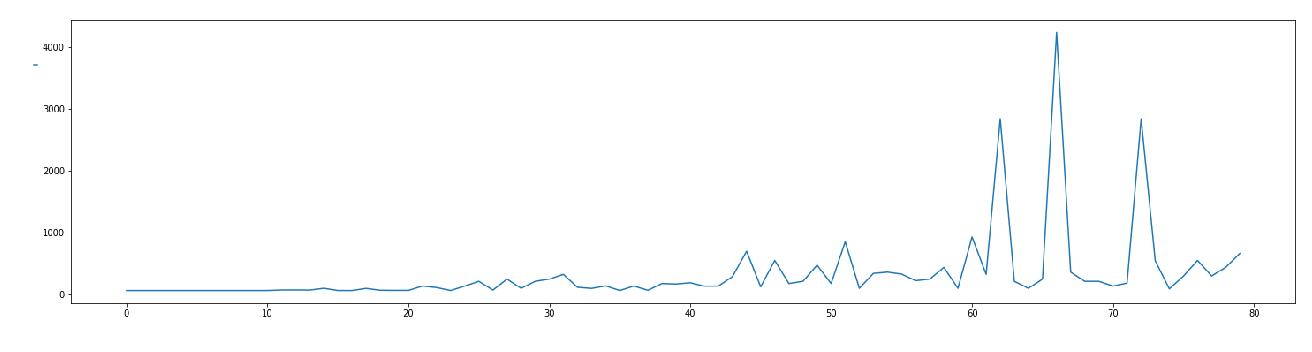

In [30]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
# plt.show()

img = mpimg.imread('/home/ccchen/sychou/labs/lab16/plots/life.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

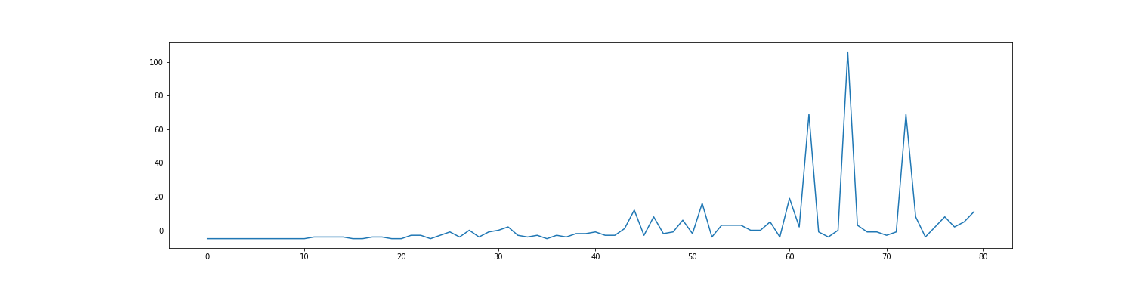

In [31]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
# plt.show()

img = mpimg.imread('/home/ccchen/sychou/labs/lab16/plots/reward.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()